In [ ]:
# -*- coding: utf-8 -*-
"""
This script aggregates all necessary imports for a comprehensive deep learning
pipeline focused on computer vision tasks. It includes libraries for data handling,
model creation, training, evaluation, and visualization using PyTorch.
"""

# =============================================================================
#                               STANDARD LIBRARY IMPORTS
# =============================================================================
import logging
import os
import random

# =============================================================================
#                               THIRD-PARTY IMPORTS
# =============================================================================

# --- Data Science & Numerical ---
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    cohen_kappa_score,
    confusion_matrix,
    f1_score,
    mean_absolute_error,
    mean_squared_error,
    roc_auc_score,
)
from sklearn.preprocessing import label_binarize

# --- Image Processing & Visualization ---
import cv2
import matplotlib.pyplot as plt
from PIL import Image

# --- Deep Learning (PyTorch) ---
import torch
import torch.backends.cudnn as cudnn
import torch.hub
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import ConcatDataset, DataLoader, Dataset, random_split
from torchvision import transforms

# --- Utilities ---
from tqdm import tqdm

In [ ]:
# Configure basic logging to capture only ERROR level messages and above.
# This helps in debugging issues related to data loading without cluttering
# the console with less critical information.
# Format: Timestamp - Log Level - Log Message
logging.basicConfig(
    level=logging.ERROR, 
    format='%(asctime)s - %(levelname)s - %(message)s'
)

class RetinalDataset(Dataset):
    """
    Custom PyTorch Dataset for loading retinal images.

    This class assumes a directory structure where each subdirectory in `data_dir`
    is named with an integer class label (e.g., '0', '1', '2'), and each
    subdirectory contains the corresponding images.

    Args:
        data_dir (str): The path to the root directory of the dataset.
        transform (callable, optional): A function/transform to apply to the images.
                                        Typically a `torchvision.transforms.Compose` object.
                                        Defaults to None.
    """
    def __init__(self, data_dir, transform=None):
        """
        Initializes the dataset by scanning the data directory and populating
        the lists of image paths and corresponding labels.
        """
        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Iterate through each class folder, assuming folder names are integer labels.
        # Sorting ensures a consistent order.
        for class_label in sorted(os.listdir(data_dir)):
            class_dir = os.path.join(data_dir, class_label)

            # Process only if the path is a directory.
            if os.path.isdir(class_dir):
                # Iterate through each image file in the class directory.
                for img_name in os.listdir(class_dir):
                    # Consider only common image file extensions.
                    if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                        img_path = os.path.join(class_dir, img_name)
                        self.image_paths.append(img_path)
                        # Convert the folder name (class label) to an integer.
                        self.labels.append(int(class_label))
    
    def __len__(self):
        """
        Returns the total number of samples in the dataset.
        Required for the Dataset interface.
        """
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        """
        Retrieves a single sample (image and label) from the dataset at the
        specified index.

        Args:
            idx (int): The index of the sample to retrieve.

        Returns:
            tuple: A tuple containing the transformed image and its integer label.
                   (image, label)

        Raises:
            Exception: Re-raises exceptions caught during image loading after logging
                       the error, which can be handled by the DataLoader.
        """
        img_path = self.image_paths[idx]
        try:
            # Open the image using PIL and convert to RGB to ensure a consistent 3-channel format.
            image = Image.open(img_path).convert('RGB')
            label = self.labels[idx]

            # Apply the specified transformations (e.g., resizing, normalization, tensor conversion).
            if self.transform:
                image = self.transform(image)
            
            return image, label
            
        except Exception as e:
            # Log any error encountered while opening or processing an image.
            # This is crucial for identifying corrupted files in the dataset.
            logging.error(f"Error opening or processing image: {img_path}")
            # Re-raising the exception allows PyTorch's DataLoader to handle it,
            # for example by skipping the corrupt sample.
            raise e

In [ ]:
# =============================================================================
#                              MAIN SETTINGS & PATHS
# =============================================================================

# Define the path for the primary dataset, which will be used for both
# training and validation.
aptos_path = "C:/Users/labor/Desktop/Genito/dinov2/Dataset_resize/2_APTOS"

# Define a list of paths for the test datasets. This allows for combining
# multiple data sources (e.g., EyePACS and DDR) into a single, comprehensive test set.
test_data_paths = [
    "C:/Users/labor/Desktop/Genito/dinov2/Dataset_resize/7_EyePACS",
    "C:/Users/labor/Desktop/Genito/dinov2/Dataset_resize/8_DDR"
]

# =============================================================================
#                    IMAGE TRANSFORMATIONS & NORMALIZATION
# =============================================================================

# ImageNet default mean and standard deviation, commonly used for transfer learning
# with models pre-trained on ImageNet, such as DINOv2.
IMAGENET_DEFAULT_MEAN = (0.485, 0.456, 0.406)
IMAGENET_DEFAULT_STD = (0.229, 0.224, 0.225)

# Transformation pipeline for the training set.
# Includes data augmentation (random flips and rotations) to help the model
# generalize better and prevent overfitting.
train_transform = transforms.Compose([
    transforms.Resize((504, 504)),
    transforms.RandomApply([transforms.RandomHorizontalFlip()], p=0.3),
    transforms.RandomApply([transforms.RandomRotation(5)], p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD)
])

# Transformation pipeline for the validation and test sets.
# No random augmentations are applied to ensure consistent and reproducible
# evaluation of the model's performance.
test_transform = transforms.Compose([
    transforms.Resize((504, 504)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD)
])

# =============================================================================
#                 TRAINING & VALIDATION DATASET PREPARATION
# =============================================================================

# 1. Load the entire APTOS dataset initially without any transforms.
# This allows us to split it first and then apply different transforms to each subset.
full_aptos_dataset = RetinalDataset(aptos_path, transform=None) 

# 2. Dynamically determine the number of classes from the dataset labels.
num_classes = len(set(full_aptos_dataset.labels))
print(f"Number of classes detected: {num_classes}")

# 3. Split the dataset into training and validation subsets (e.g., 80% train, 20% val).
# `random_split` creates `torch.utils.data.Subset` objects, which wrap the original dataset.
validation_split = 0.2
dataset_size = len(full_aptos_dataset)
val_size = int(validation_split * dataset_size)
train_size = dataset_size - val_size
train_subset, val_subset = random_split(full_aptos_dataset, [train_size, val_size])

# 4. Apply the correct transformation pipelines to each subset.
# This is a key step: we access the original dataset through `subset.dataset`
# and set its `transform` attribute. This effectively assigns the correct
# transform to be used when data is fetched from that specific subset.
train_subset.dataset.transform = train_transform
val_subset.dataset.transform = test_transform # Use the non-augmented transform for validation.

# 5. Create DataLoaders for the training and validation subsets.
# `shuffle=True` for the training loader is crucial for model learning.
# `pin_memory=True` can speed up data transfer to the GPU.
train_loader = DataLoader(train_subset, batch_size=8, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_subset, batch_size=8, shuffle=False, pin_memory=True)

print(f"Number of samples in training set: {len(train_subset)}")
print(f"Number of samples in validation set: {len(val_subset)}")

# =============================================================================
#                           TEST DATASET PREPARATION
# =============================================================================

# Create a list of `RetinalDataset` objects from the specified test paths.
test_datasets = []
for path in test_data_paths:
    if os.path.exists(path):  # Defensive check to ensure the path exists.
        test_datasets.append(RetinalDataset(path, transform=test_transform))
    else:
        print(f"Warning: Test path not found and skipped: {path}")

# Combine the individual test datasets into a single logical dataset using `ConcatDataset`.
# This is ideal for evaluating the model on multiple data sources seamlessly.
test_dataset = ConcatDataset(test_datasets)

# Create the DataLoader for the final test set.
# `shuffle=False` is used to ensure evaluation is done in a consistent order.
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, pin_memory=True)

print(f"Total number of samples in the combined test set: {len(test_dataset)}")

Numero di classi: 5
Numero di campioni nel training set: 2067
Numero di campioni nel validation set: 516
Numero totale di campioni nel test set: 102369


In [ ]:
# =============================================================================
#                  MODEL SETUP FOR FINE-TUNING DINOv2
#
# This script configures a pre-trained DINOv2 model for a downstream
# classification task. It involves:
# 1. Loading the giant Vision Transformer (ViT-G/14) DINOv2 model.
# 2. Implementing a partial fine-tuning strategy by freezing the initial
#    layers and unfreezing only the final transformer blocks.
# 3. Attaching a custom classification head to the DINOv2 backbone.
# =============================================================================

# Set the computation device to CUDA if a compatible GPU is available, otherwise use CPU.
# This is standard practice for deep learning to leverage GPU acceleration.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pre-trained DINOv2 model with a ViT-G/14 backbone using torch.hub.
# The `_reg` suffix indicates the model variant trained with registers.
print("Loading DINOv2 pre-trained backbone...")
backbone = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitg14_reg').to(device)
print("Backbone loaded successfully.")

# --- Fine-Tuning Strategy: Partial Unfreezing ---

# 1. Freeze all parameters in the backbone by default.
# This prevents the pre-trained weights from being updated during the initial
# phase of training, preserving the powerful, general features learned by DINOv2.
for param in backbone.parameters():
    param.requires_grad = False

# 2. Unfreeze only the last few transformer blocks for fine-tuning.
# This allows the model to adapt its most high-level features to the specifics
# of the new dataset without suffering from catastrophic forgetting.
# The block indices (35-39) are chosen as they are the final layers of the ViT-G model.
print("Unfreezing final layers of the backbone for fine-tuning...")
for name, param in backbone.named_parameters():
    # To inspect all layer names, uncomment the following line:
    # print(name)
    if any(b in name for b in ['blocks.35.', 'blocks.36.', 'blocks.37.', 'blocks.38.', 'blocks.39.']):
        param.requires_grad = True
        print(f"  - Unfroze layer: {name}")

class ClassificationHead(nn.Module):
    """
    A wrapper module that combines the DINOv2 backbone with a new classifier.

    This class handles the forward pass through the backbone, extracts the
    appropriate feature vector ([CLS] token), and passes it to a sequential
    classifier for the final prediction.

    Args:
        backbone (nn.Module): The pre-trained DINOv2 model.
        num_classes (int): The number of output classes for the classification task.
    """
    def __init__(self, backbone, num_classes=5):
        super(ClassificationHead, self).__init__()
        self.backbone = backbone
        
        # The feature dimension of the DINOv2 ViT-G/14 model output.
        feature_dim = 1536
        
        # Define a simple MLP (Multi-Layer Perceptron) as the classifier.
        self.classifier = nn.Sequential(
            nn.Linear(feature_dim, 512),  # Input layer from backbone feature dim
            nn.ReLU(),                    # Activation function for non-linearity
            nn.Dropout(0.3),              # Dropout for regularization to prevent overfitting
            nn.Linear(512, num_classes)   # Output layer mapping to the number of classes
        )
    
    def forward(self, x):
        """
        Defines the forward pass of the model.
        
        Args:
            x (torch.Tensor): The input batch of images.
            
        Returns:
            torch.Tensor: The output logits from the classifier.
        """
        # Get the feature embeddings from the DINOv2 backbone.
        features = self.backbone(x)
        
        # DINOv2's output format can vary. This block robustly extracts the
        # CLS token embedding, which is the standard representation for classification.
        if isinstance(features, dict) and "x_norm_clstoken" in features:
            # Handles output from models trained with registers.
            features_cls = features["x_norm_clstoken"]
        elif isinstance(features, tuple):
            # Assumes the first element of a tuple output is the CLS token.
            features_cls = features[0]
        else:
            # Fallback for when the backbone returns a raw tensor directly.
            features_cls = features
        
        # Pass the extracted CLS token through the custom classifier.
        return self.classifier(features_cls)

Using cache found in C:\Users\labor/.cache\torch\hub\facebookresearch_dinov2_main
C:\Users\labor/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
C:\Users\labor/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
C:\Users\labor/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


Avvio training da zero (nessun resume).


Training epoch 1/60:   0%|          | 0/259 [00:00<?, ?it/s]c:\Users\labor\Desktop\Genito\dinov2\venv\lib\site-packages\xformers\ops\unbind.py:46: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage_data_ptr = tensors[0].storage().data_ptr()
c:\Users\labor\Desktop\Genito\dinov2\venv\lib\site-packages\xformers\ops\unbind.py:48: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if x.storage().data_ptr() != storage_data_ptr:
Training epoch 1/60: 100%|██████████| 259/259 [07:46<00:00,  1.80s/it]


[Epoca 1/60] Train Loss: 0.7774
Validation Loss: 0.5214 | Accuracy: 0.7888 | F1 Macro: 0.5098 | AUC: 0.9312
-> Miglior val_loss. Modello salvato (0.5214).


Training epoch 2/60:   0%|          | 0/259 [00:00<?, ?it/s]c:\Users\labor\Desktop\Genito\dinov2\venv\lib\site-packages\xformers\ops\unbind.py:46: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage_data_ptr = tensors[0].storage().data_ptr()
c:\Users\labor\Desktop\Genito\dinov2\venv\lib\site-packages\xformers\ops\unbind.py:48: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if x.storage().data_ptr() != storage_data_ptr:
Training epoch 2/60: 100%|██████████| 259/259 [07:53<00:00,  1.83s/it]


[Epoca 2/60] Train Loss: 0.4936
Validation Loss: 0.4521 | Accuracy: 0.8275 | F1 Macro: 0.5312 | AUC: 0.9440
-> Miglior val_loss. Modello salvato (0.4521).


Training epoch 3/60:   0%|          | 0/259 [00:00<?, ?it/s]c:\Users\labor\Desktop\Genito\dinov2\venv\lib\site-packages\xformers\ops\unbind.py:46: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage_data_ptr = tensors[0].storage().data_ptr()
c:\Users\labor\Desktop\Genito\dinov2\venv\lib\site-packages\xformers\ops\unbind.py:48: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if x.storage().data_ptr() != storage_data_ptr:
Training epoch 3/60: 100%|██████████| 259/259 [07:53<00:00,  1.83s/it]


[Epoca 3/60] Train Loss: 0.4570
Validation Loss: 0.4212 | Accuracy: 0.8353 | F1 Macro: 0.6123 | AUC: 0.9489
-> Miglior val_loss. Modello salvato (0.4212).


Training epoch 4/60:   0%|          | 0/259 [00:00<?, ?it/s]c:\Users\labor\Desktop\Genito\dinov2\venv\lib\site-packages\xformers\ops\unbind.py:46: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage_data_ptr = tensors[0].storage().data_ptr()
c:\Users\labor\Desktop\Genito\dinov2\venv\lib\site-packages\xformers\ops\unbind.py:48: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if x.storage().data_ptr() != storage_data_ptr:
Training epoch 4/60: 100%|██████████| 259/259 [08:00<00:00,  1.86s/it]


[Epoca 4/60] Train Loss: 0.4195
Validation Loss: 0.3908 | Accuracy: 0.8256 | F1 Macro: 0.5453 | AUC: 0.9530
-> Miglior val_loss. Modello salvato (0.3908).


Training epoch 5/60:   0%|          | 0/259 [00:00<?, ?it/s]c:\Users\labor\Desktop\Genito\dinov2\venv\lib\site-packages\xformers\ops\unbind.py:46: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage_data_ptr = tensors[0].storage().data_ptr()
c:\Users\labor\Desktop\Genito\dinov2\venv\lib\site-packages\xformers\ops\unbind.py:48: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if x.storage().data_ptr() != storage_data_ptr:
Training epoch 5/60: 100%|██████████| 259/259 [07:59<00:00,  1.85s/it]


[Epoca 5/60] Train Loss: 0.3793
Validation Loss: 0.4070 | Accuracy: 0.8430 | F1 Macro: 0.6174 | AUC: 0.9514
Pazienza: 1/7


Training epoch 6/60:   0%|          | 0/259 [00:00<?, ?it/s]c:\Users\labor\Desktop\Genito\dinov2\venv\lib\site-packages\xformers\ops\unbind.py:46: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage_data_ptr = tensors[0].storage().data_ptr()
c:\Users\labor\Desktop\Genito\dinov2\venv\lib\site-packages\xformers\ops\unbind.py:48: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if x.storage().data_ptr() != storage_data_ptr:
Training epoch 6/60: 100%|██████████| 259/259 [08:02<00:00,  1.86s/it]


[Epoca 6/60] Train Loss: 0.3593
Validation Loss: 0.4186 | Accuracy: 0.8450 | F1 Macro: 0.5911 | AUC: 0.9515
Pazienza: 2/7


Training epoch 7/60:   0%|          | 0/259 [00:00<?, ?it/s]c:\Users\labor\Desktop\Genito\dinov2\venv\lib\site-packages\xformers\ops\unbind.py:46: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage_data_ptr = tensors[0].storage().data_ptr()
c:\Users\labor\Desktop\Genito\dinov2\venv\lib\site-packages\xformers\ops\unbind.py:48: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if x.storage().data_ptr() != storage_data_ptr:
Training epoch 7/60: 100%|██████████| 259/259 [08:02<00:00,  1.86s/it]


[Epoca 7/60] Train Loss: 0.3445
Validation Loss: 0.3829 | Accuracy: 0.8469 | F1 Macro: 0.6568 | AUC: 0.9533
-> Miglior val_loss. Modello salvato (0.3829).


Training epoch 8/60:   0%|          | 0/259 [00:00<?, ?it/s]c:\Users\labor\Desktop\Genito\dinov2\venv\lib\site-packages\xformers\ops\unbind.py:46: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage_data_ptr = tensors[0].storage().data_ptr()
c:\Users\labor\Desktop\Genito\dinov2\venv\lib\site-packages\xformers\ops\unbind.py:48: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if x.storage().data_ptr() != storage_data_ptr:
Training epoch 8/60: 100%|██████████| 259/259 [07:52<00:00,  1.82s/it]


[Epoca 8/60] Train Loss: 0.3243
Validation Loss: 0.4216 | Accuracy: 0.8488 | F1 Macro: 0.6034 | AUC: 0.9507
Pazienza: 1/7


Training epoch 9/60:   0%|          | 0/259 [00:00<?, ?it/s]c:\Users\labor\Desktop\Genito\dinov2\venv\lib\site-packages\xformers\ops\unbind.py:46: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage_data_ptr = tensors[0].storage().data_ptr()
c:\Users\labor\Desktop\Genito\dinov2\venv\lib\site-packages\xformers\ops\unbind.py:48: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if x.storage().data_ptr() != storage_data_ptr:
Training epoch 9/60: 100%|██████████| 259/259 [07:49<00:00,  1.81s/it]


[Epoca 9/60] Train Loss: 0.2858
Validation Loss: 0.4108 | Accuracy: 0.8547 | F1 Macro: 0.6164 | AUC: 0.9535
Pazienza: 2/7


Training epoch 10/60:   0%|          | 0/259 [00:00<?, ?it/s]c:\Users\labor\Desktop\Genito\dinov2\venv\lib\site-packages\xformers\ops\unbind.py:46: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage_data_ptr = tensors[0].storage().data_ptr()
c:\Users\labor\Desktop\Genito\dinov2\venv\lib\site-packages\xformers\ops\unbind.py:48: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if x.storage().data_ptr() != storage_data_ptr:
Training epoch 10/60: 100%|██████████| 259/259 [07:56<00:00,  1.84s/it]


[Epoca 10/60] Train Loss: 0.2625
Validation Loss: 0.4563 | Accuracy: 0.8430 | F1 Macro: 0.6594 | AUC: 0.9523
Pazienza: 3/7


Training epoch 11/60:   0%|          | 0/259 [00:00<?, ?it/s]c:\Users\labor\Desktop\Genito\dinov2\venv\lib\site-packages\xformers\ops\unbind.py:46: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage_data_ptr = tensors[0].storage().data_ptr()
c:\Users\labor\Desktop\Genito\dinov2\venv\lib\site-packages\xformers\ops\unbind.py:48: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if x.storage().data_ptr() != storage_data_ptr:
Training epoch 11/60: 100%|██████████| 259/259 [07:46<00:00,  1.80s/it]


[Epoca 11/60] Train Loss: 0.2301
Validation Loss: 0.4344 | Accuracy: 0.8314 | F1 Macro: 0.6289 | AUC: 0.9481
Pazienza: 4/7


Training epoch 12/60:   0%|          | 0/259 [00:00<?, ?it/s]c:\Users\labor\Desktop\Genito\dinov2\venv\lib\site-packages\xformers\ops\unbind.py:46: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage_data_ptr = tensors[0].storage().data_ptr()
c:\Users\labor\Desktop\Genito\dinov2\venv\lib\site-packages\xformers\ops\unbind.py:48: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if x.storage().data_ptr() != storage_data_ptr:
Training epoch 12/60: 100%|██████████| 259/259 [07:48<00:00,  1.81s/it]


[Epoca 12/60] Train Loss: 0.1971
Validation Loss: 0.5302 | Accuracy: 0.8372 | F1 Macro: 0.6415 | AUC: 0.9465
Pazienza: 5/7


Training epoch 13/60:   0%|          | 0/259 [00:00<?, ?it/s]c:\Users\labor\Desktop\Genito\dinov2\venv\lib\site-packages\xformers\ops\unbind.py:46: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage_data_ptr = tensors[0].storage().data_ptr()
c:\Users\labor\Desktop\Genito\dinov2\venv\lib\site-packages\xformers\ops\unbind.py:48: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if x.storage().data_ptr() != storage_data_ptr:
Training epoch 13/60: 100%|██████████| 259/259 [08:17<00:00,  1.92s/it]


[Epoca 13/60] Train Loss: 0.1630
Validation Loss: 0.5850 | Accuracy: 0.8372 | F1 Macro: 0.6125 | AUC: 0.9468
Pazienza: 6/7


Training epoch 14/60:   0%|          | 0/259 [00:00<?, ?it/s]c:\Users\labor\Desktop\Genito\dinov2\venv\lib\site-packages\xformers\ops\unbind.py:46: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage_data_ptr = tensors[0].storage().data_ptr()
c:\Users\labor\Desktop\Genito\dinov2\venv\lib\site-packages\xformers\ops\unbind.py:48: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if x.storage().data_ptr() != storage_data_ptr:
Training epoch 14/60: 100%|██████████| 259/259 [07:52<00:00,  1.83s/it]


[Epoca 14/60] Train Loss: 0.1499
Validation Loss: 0.5630 | Accuracy: 0.8430 | F1 Macro: 0.6544 | AUC: 0.9457
Pazienza: 7/7
Early stopping all'epoca 14.


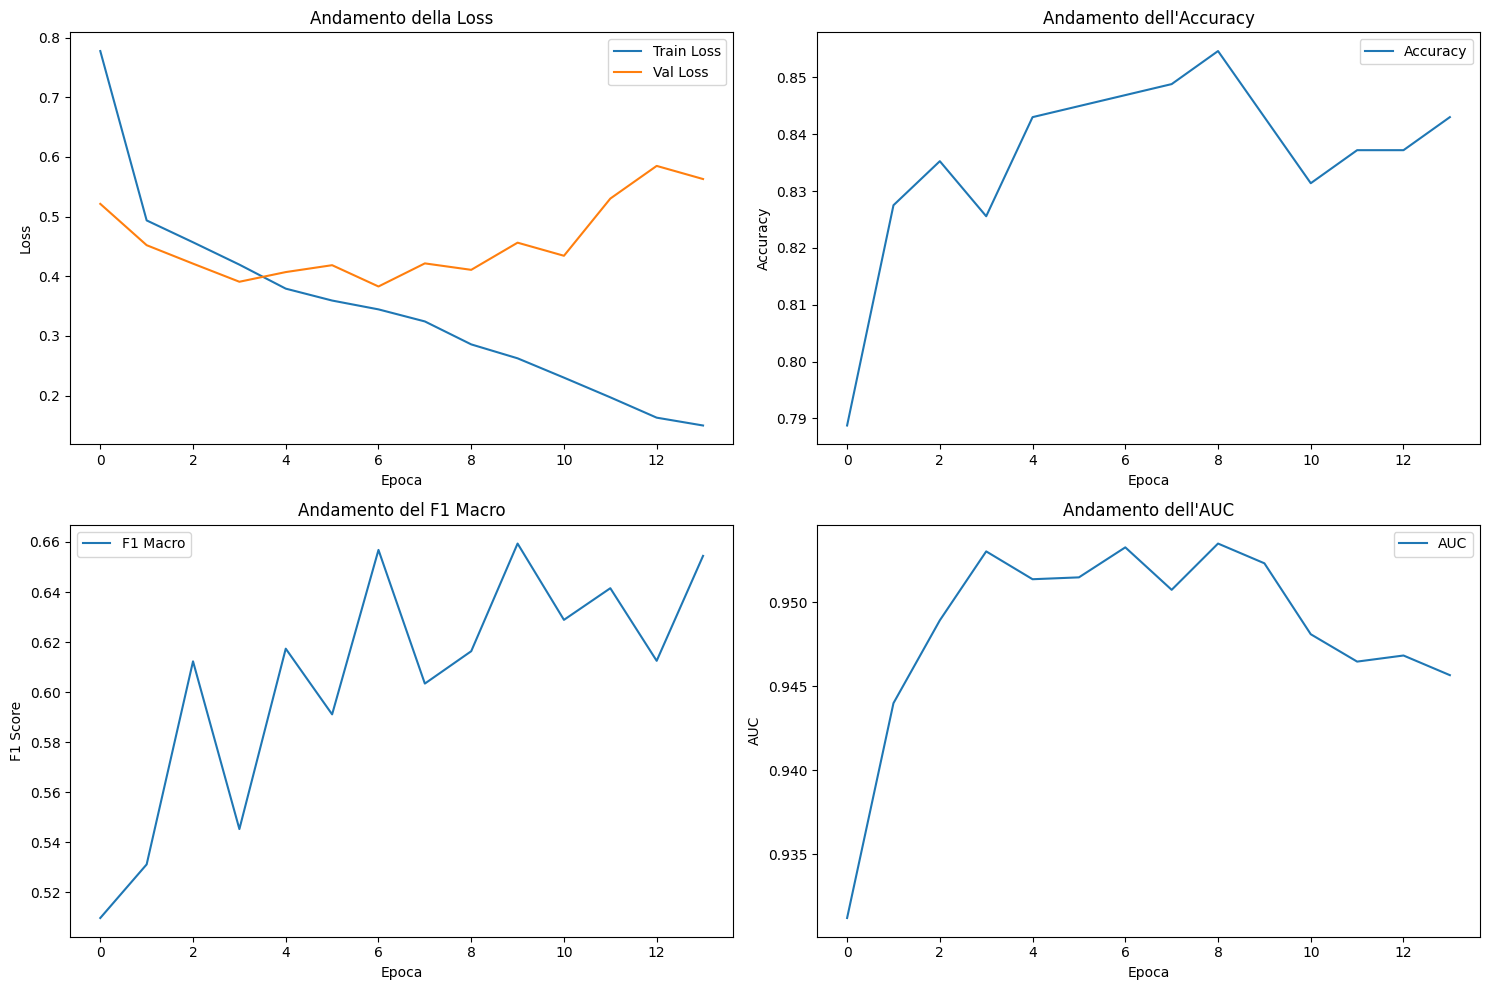

Addestramento completato!
Miglior accuracy (storica): 0.8547
Miglior validation loss: 0.3829


In [ ]:
# =============================================================================
#                           REPRODUCIBILITY SETUP
# =============================================================================
# Set a fixed seed for all relevant random number generators to ensure that
# experimental results are reproducible across different runs.
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# Optional CuDNN settings for full determinism.
# Note: This can sometimes have a minor performance cost but guarantees
# identical results on the same hardware.
cudnn.deterministic = True

# =============================================================================
#                           MAIN TRAINING FUNCTION
# =============================================================================

def train_model(train_loader, val_loader, resume=False):
    """
    Trains and validates a deep learning model with a full suite of features.

    This function encapsulates the entire training pipeline, including:
    - Model and optimizer setup with differential learning rates.
    - An epoch-based training and validation loop.
    - A robust checkpointing system to save and resume training state.
    - Early stopping based on validation loss to prevent overfitting.
    - Real-time logging and post-training plotting of key performance metrics.

    Args:
        train_loader (DataLoader): DataLoader for the training dataset.
        val_loader (DataLoader): DataLoader for the validation dataset.
        resume (bool): If True, attempts to resume training from the last checkpoint.
    """
    # --- 1. Initialization and Setup ---
    # Set the computation device; "cuda:1" targets the second available GPU.
    device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
    
    # Training hyperparameters
    num_classes = 5
    num_epochs = 60
    patience = 7  # Number of epochs to wait for improvement before early stopping
    
    # Checkpoint directory setup
    checkpoint_dir = 'C:/Users/labor/Desktop/Genito/dinov2/ESDG/APTOS'
    os.makedirs(checkpoint_dir, exist_ok=True)
    
    # Model definition
    model = ClassificationHead(backbone, num_classes=num_classes).to(device)
    
    # Optimizer with differential learning rates: a key fine-tuning technique.
    # The pre-trained backbone uses a very low learning rate (1e-6) to avoid
    # corrupting its learned features, while the new classifier head uses a
    # higher learning rate (1e-3) to learn the new task quickly.
    optimizer = optim.AdamW([
        {'params': model.backbone.parameters(), 'lr': 1e-6},
        {'params': model.classifier.parameters(), 'lr': 1e-3}
    ])
    
    # Loss function for multi-class classification
    criterion = nn.CrossEntropyLoss()

    # State-tracking variables for metrics and early stopping
    best_val_loss = float('inf')
    best_accuracy = 0.0
    patience_counter = 0
    start_epoch = 0
    
    # History dictionary to store metrics for each epoch for later plotting.
    history = {
        'train_loss': [], 'val_loss': [], 'accuracy': [],
        'f1_macro': [], 'auc': []
    }
    
    # --- 2. Resume from Checkpoint Logic ---
    latest_checkpoint_path = os.path.join(checkpoint_dir, 'lastest_checkpoint.pth')

    if resume and os.path.exists(latest_checkpoint_path):
        print(f"Resuming training from checkpoint: {latest_checkpoint_path}")
        checkpoint = torch.load(latest_checkpoint_path, map_location=device)
        
        # Restore the state of the model and optimizer
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        
        # Restore all tracking variables to continue the training run seamlessly
        start_epoch = checkpoint['epoch'] + 1
        best_val_loss = checkpoint['best_val_loss']
        best_accuracy = checkpoint['best_accuracy']
        patience_counter = checkpoint['patience_counter']
        history = checkpoint['history']
        
        print(f"Resumed from epoch {start_epoch}. Best validation loss so far: {best_val_loss:.4f}")
    else:
        if resume:
            print(f"Resume requested, but no checkpoint found. Starting from scratch.")
        else:
            print("Starting training from scratch.")

    # ========================================================= #
    #                       3. TRAINING LOOP
    # ========================================================= #
    for epoch in range(start_epoch, num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        
        # Training phase
        for images, labels in tqdm(train_loader, desc=f"Training epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        train_loss = running_loss / len(train_loader)
        history['train_loss'].append(train_loss)
        
        print(f"\n[Epoch {epoch+1}/{num_epochs}] Train Loss: {train_loss:.4f}")
        
        # --- Validation Phase ---
        model.eval()  # Set the model to evaluation mode
        val_running_loss = 0.0
        all_preds, all_labels, all_probs = [], [], []
        
        with torch.no_grad():  # Disable gradient calculation for efficiency
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                
                val_loss = criterion(outputs, labels)
                val_running_loss += val_loss.item()
                
                # Store predictions and probabilities for metric calculation
                probabilities = torch.softmax(outputs, dim=1)
                _, predicted = torch.max(outputs, 1)
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probabilities.cpu().numpy())
        
        val_loss = val_running_loss / len(val_loader)
        history['val_loss'].append(val_loss)
        
        # --- Calculate and log validation metrics ---
        accuracy_val = accuracy_score(all_labels, all_preds)
        f1_macro = f1_score(all_labels, all_preds, average='macro')
        all_labels_bin = label_binarize(all_labels, classes=list(range(num_classes)))
        auc_val = roc_auc_score(all_labels_bin, all_probs, multi_class='ovr')
        
        history['accuracy'].append(accuracy_val)
        history['f1_macro'].append(f1_macro)
        history['auc'].append(auc_val)
        
        print(f"Validation -> Loss: {val_loss:.4f} | Accuracy: {accuracy_val:.4f} | F1 Macro: {f1_macro:.4f} | AUC: {auc_val:.4f}")
        
        best_accuracy = max(accuracy_val, best_accuracy)

        # --- 4. Early Stopping & Best Model Saving ---
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Save the model state dict that achieved the best validation loss
            torch.save(model.state_dict(), f'best_dinov2_APTOS_ESDG_epoch_{epoch+1}.pth')
            print(f"-> New best validation loss. Model saved ({best_val_loss:.4f}).")
        else:
            patience_counter += 1
            print(f"  Patience: {patience_counter}/{patience}")
            if patience_counter >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}.")
                break  # Exit the training loop
        
        # --- 5. Save Checkpoint After Each Epoch ---
        # This allows the training to be recovered from any interruption.
        checkpoint_data = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_loss': best_val_loss,
            'best_accuracy': best_accuracy,
            'patience_counter': patience_counter,
            'history': history
        }
        torch.save(checkpoint_data, latest_checkpoint_path)
    
    # --- 6. Post-Training Analysis & Plotting ---
    print("\nTraining complete.")
    print(f"Best recorded validation accuracy: {best_accuracy:.4f}")
    print(f"Best recorded validation loss: {best_val_loss:.4f}")

    plt.figure(figsize=(15, 10))
    plt.suptitle("Training & Validation Metrics Over Epochs", fontsize=16)

    plt.subplot(2, 2, 1); plt.plot(history['train_loss'], label='Train Loss'); plt.plot(history['val_loss'], label='Val Loss'); plt.title('Loss'); plt.legend(); plt.grid(True)
    plt.subplot(2, 2, 2); plt.plot(history['accuracy'], label='Accuracy', color='green'); plt.title('Accuracy'); plt.legend(); plt.grid(True)
    plt.subplot(2, 2, 3); plt.plot(history['f1_macro'], label='F1 Macro', color='red'); plt.title('F1 Macro'); plt.legend(); plt.grid(True)
    plt.subplot(2, 2, 4); plt.plot(history['auc'], label='AUC', color='purple'); plt.title('AUC (OvR)'); plt.legend(); plt.grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig('training_metrics.png')
    plt.show()

# =============================================================================
#                           EXECUTION BLOCK
# =============================================================================

# Prompt the user to decide whether to resume training from the last checkpoint.
flag = input("Resume training from the last checkpoint? (y/yes to resume): ")
resume_flag = flag.lower() in ["y", "yes"]
    
# Launch the main training function.
train_model(train_loader, val_loader, resume=resume_flag)

Using cache found in C:\Users\labor/.cache\torch\hub\facebookresearch_dinov2_main
  0%|          | 0/12797 [00:00<?, ?it/s]c:\Users\labor\Desktop\Genito\dinov2\venv\lib\site-packages\xformers\ops\unbind.py:46: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage_data_ptr = tensors[0].storage().data_ptr()
c:\Users\labor\Desktop\Genito\dinov2\venv\lib\site-packages\xformers\ops\unbind.py:48: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if x.storage().data_ptr() != storage_data_ptr:
100%|██████████| 12797/12797 [5

Risultati finali:
AUC: 0.8031 | Acc: 0.6598 | F1 Macro: 0.2945
Accuracy: 0.6598
F1 Macro: 0.2945
AUC: 0.8031
Cohen's Kappa: 0.4461


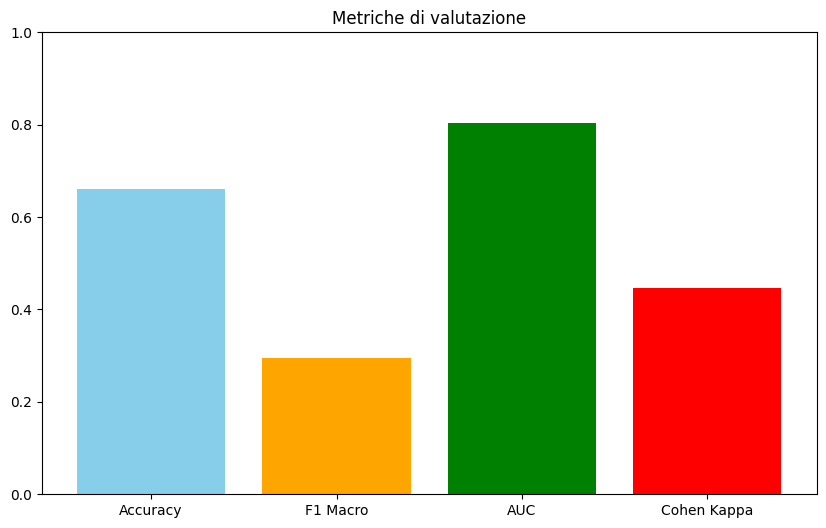

NameError: name 'sns' is not defined

<Figure size 800x600 with 0 Axes>

In [ ]:
# =============================================================================
#                        MODEL EVALUATION ON TEST SET
#
# This script loads the best-performing model checkpoint from the training
# phase and evaluates its performance on the unseen test dataset.
# It calculates and visualizes a comprehensive set of classification metrics,
# including a confusion matrix, to provide a final assessment of the model.
# =============================================================================

# --- 1. Model and Environment Setup ---

# Set the computation device; "cuda:1" targets the second GPU.
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

# The 'backbone' variable is assumed to be loaded and configured from the
# previous training context. The following line is for architecture definition,
# not for re-loading weights.
torch.hub.load('facebookresearch/dinov2', 'dinov2_vitg14_reg').to(device)
    
# Instantiate the full model (backbone + classification head).
model = ClassificationHead(backbone, num_classes=5).to(device)

# Load the saved weights from the best model checkpoint.
# This file should contain the state_dict of the model that achieved the
# lowest validation loss during training.
print("Loading best model weights for evaluation...")
model.load_state_dict(torch.load('best_dinov2_APTOS_ESDG_epoch_2.pth'))

# Set the model to evaluation mode. This is crucial as it disables layers
# like Dropout and sets BatchNorm layers to use running statistics, ensuring
# deterministic output for inference.
model.eval()
print("Model loaded and set to evaluation mode.")


# --- 2. Inference on the Test Set ---
# Initialize lists to store the ground truth labels, model predictions,
# and output probabilities for later metric calculation.
all_preds = []
all_labels = []
all_probs = []

# `torch.no_grad()` context manager disables gradient calculation, which
# reduces memory consumption and speeds up inference significantly.
with torch.no_grad():
    # Iterate over the test_loader with a progress bar.
    for images, labels in tqdm(test_loader, desc="Evaluating on Test Set"):
        # Move data to the configured device.
        images, labels = images.to(device), labels.to(device)
        
        # Perform a forward pass to get model outputs (logits).
        outputs = model(images)
        
        # Convert logits to probabilities using softmax for AUC calculation.
        probabilities = torch.softmax(outputs, dim=1)
        
        # Get the predicted class index by finding the max logit.
        _, predicted = torch.max(outputs, 1)
        
        # Append results to the lists, moving them back to the CPU.
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probabilities.cpu().numpy())


# --- 3. Final Metrics Calculation ---
# Convert lists to NumPy arrays for efficient computation with scikit-learn.
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
all_probs = np.array(all_probs)

# Calculate a suite of standard classification metrics.
accuracy_val = accuracy_score(all_labels, all_preds)
f1_macro = f1_score(all_labels, all_preds, average='macro')

# For multi-class AUC, binarize the labels and use the One-vs-Rest strategy.
num_classes = 5 
all_labels_bin = label_binarize(all_labels, classes=list(range(num_classes)))
auc = roc_auc_score(all_labels_bin, all_probs, multi_class='ovr')

# Cohen's Kappa is excellent for imbalanced classes and multi-class problems.
# 'linear' weighting is appropriate for ordinal data (where classes have an order).
cohen_kappa = cohen_kappa_score(all_labels, all_preds, weights='linear')

# Print a clear summary of the final results.
print("\n--- Final Test Set Results ---")
print(f"Accuracy:               {accuracy_val:.4f}")
print(f"F1 Score (Macro):       {f1_macro:.4f}")
print(f"AUC (One-vs-Rest):      {auc:.4f}")
print(f"Cohen's Kappa (Linear): {cohen_kappa:.4f}")
print("----------------------------\n")


# --- 4. Results Visualization ---

# (a) Bar chart for a high-level overview of the key metrics.
plt.figure(figsize=(10, 6))
metrics_names = ['Accuracy', 'F1 Macro', 'AUC', 'Cohen Kappa']
metrics_values = [accuracy_val, f1_macro, auc, cohen_kappa]
bars = plt.bar(metrics_names, metrics_values, color=['#0077b6', '#f4a261', '#2a9d8f', '#e76f51'])
plt.title('Final Model Evaluation Metrics on Test Set', fontsize=16)
plt.ylabel('Score', fontsize=12)
plt.ylim(0, 1) # Set y-axis limit to be from 0 to 1.
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of the bars.
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.3f}', va='bottom', ha='center')

plt.show()

# (b) Confusion Matrix for detailed error analysis.
# The matrix shows correct predictions on the diagonal and misclassifications
# on the off-diagonal elements, providing insight into which classes the
# model struggles to differentiate.
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(range(num_classes)),
            yticklabels=list(range(num_classes)))
plt.xlabel('Predicted Class', fontsize=14)
plt.ylabel('True Class', fontsize=14)
plt.title("Confusion Matrix", fontsize=16)
plt.show()

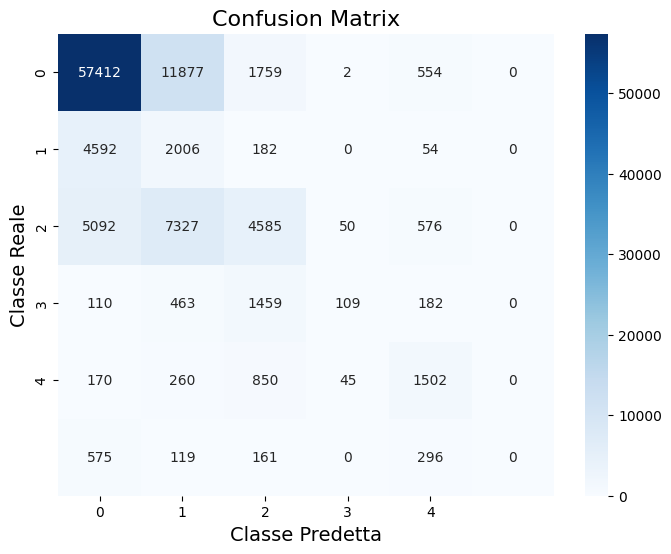

In [ ]:
import seaborn as sns
# Calcolo e visualizzazione della Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(range(num_classes)),
            yticklabels=list(range(num_classes)))
plt.xlabel('Classe Predetta', fontsize=14)
plt.ylabel('Classe Reale', fontsize=14)
plt.title("Confusion Matrix", fontsize=16)
plt.show()